# Introduction
In this tutorial we will:
* Load neural data from multiple imaging planes that were recorded simulatenously during a single 2-photon imaging session. 

* Construct event-triggered plots for single cells, and behavioral data.

* Track single cells across multiple imaging sessions. 

This is designed to demonstrate a simple method for interacting with the visual behavior data. Many aspects of the dataset are not explored here.

# Set up environment and import packages

We have built a package called `mindscope_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `mindscope_utilities` per the instrutions below.

We will first install `mindscope_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues. 

You can minimize the cell after you are done to hide the output. 

#### Install necessary packages

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

     |████████████████████████████████| 1.6MB 5.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 73 kB 1.1 MB/s 
     |████████████████████████████████| 1.7 MB 8.2 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 72 kB 696 kB/s 
     |████████████████████████████████| 130 kB 56.5 MB/s 
     |████████████████████████████████| 128 kB 57.3 MB/s 
     |████████████████████████████████| 668 kB 42.6 MB/s 
     |████████████████████████████████| 1.3 MB 38.9 MB/s 
     |████████████████████████████████| 47.4 MB 31 kB/s 
     |████████████████████████████████| 4.3 MB 35.5 MB/s 
     |████████████████████████████████| 149 kB 70.8 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 2.9 MB 28.6 MB/s 
     |████████████████████████████████| 3.4 MB 15.2 MB/s 
     |██████████████████████


#### Next we will import packages we need later in the notebook

In [53]:
# General python packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Allen Institute specific packages
import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

# makes notebook display nicer
pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [54]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id. 
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions. 
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`. 

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 

This graphic will help explain the layout of the dataset.
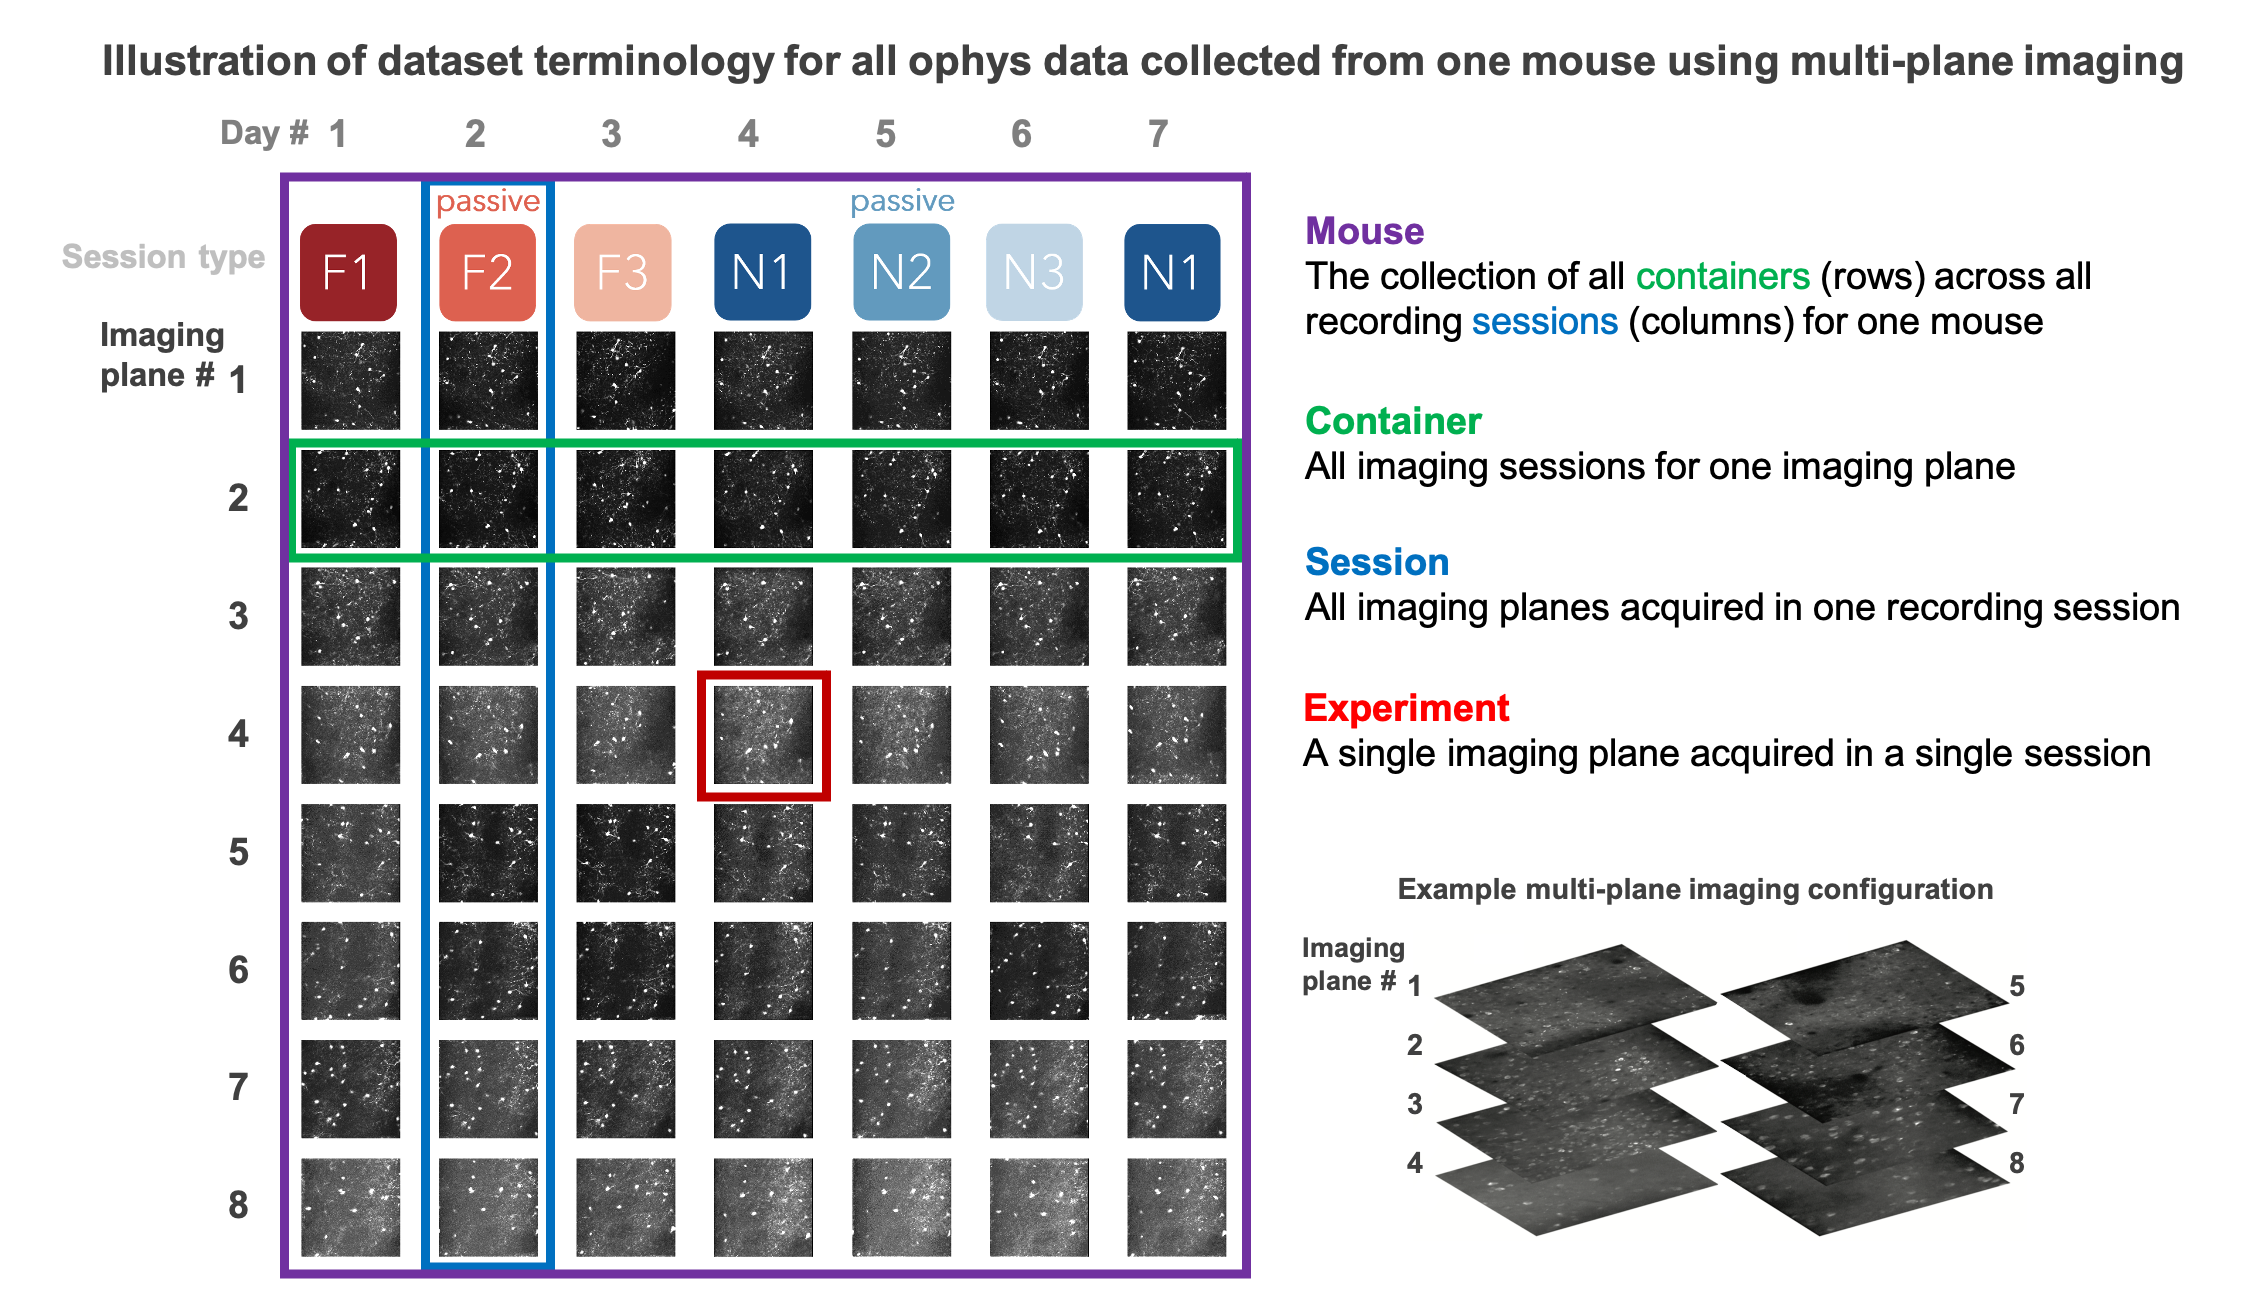

In [55]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [56]:
session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [57]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


# Load one example session
We are going to select one session from this table, session 849304162. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 7 simultaneously acquired imaging planes for this session. This session was collected using the familiar image set. 
We can view metadata for this session as follows:

In [58]:
ophys_session_id = 849304162 
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      440631
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                M
age_in_days                                                                      121
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                     1
prior_exposures_to_session_type                                                    0
prior_exposures_to_image_set                                     

# Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [59]:
# Create empty dictionary
experiments = {}

# For each experiment (imaging plane), load data into dictionary
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `visual_behavior_ophys` module of the `mindscope_utilities` package that was imported above as `ophys`. 

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [60]:
# Make Empty list, we will use to create dataframe
neural_data = []

# For each imaging plane (experiment), load data into tidy format
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 7/7 [00:40<00:00,  5.81s/it]


We can then look at some attributes of the `neural_data` dataframe we have created.

It is ~3.8 million rows long:

In [61]:
len(neural_data)

3821704

It is so long because has one row for each timestamp for each cell. 

Below are the first 5 entries. Again, note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [62]:
neural_data.head()

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,8.89238,1080857656,1086550481,1.196615,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,8.98560,1080857656,1086550481,1.130732,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,9.07882,1080857656,1086550481,1.041409,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,9.17204,1080857656,1086550481,0.148351,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,9.26526,1080857656,1086550481,0.285266,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions. 
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id. 

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [63]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell specimen ids are: {}'.format(cell_ids))

there are 79 unique cells
cell specimen ids are: [1086550481 1086551301 1086556502 1086557083 1086557208 1086557304
 1086557639 1086557794 1086557984 1086558114 1086558224 1086558510
 1086558955 1086559064 1086559206 1086559365 1086559496 1086559611
 1086560593 1086559885 1086559968 1086547322 1086547526 1086547796
 1086547993 1086548118 1086559641 1086552021 1086553015 1086553523
 1086553722 1086553907 1086555222 1086555470 1086555980 1086556317
 1086556532 1086557434 1086557839 1086559931 1086557013 1086549726
 1086550391 1086550544 1086550723 1086551151 1086551540 1086551913
 1086552709 1086553122 1086553271 1086553602 1086553836 1086547630
 1086548072 1086548658 1086548969 1086549303 1086549491 1086549813
 1086549949 1086550346 1086552408 1086551209 1086551457 1086551645
 1086547687 1086547776 1086547901 1086548411 1086548606 1086548818
 1086549154 1086549252 1086549379 1086549519 1086552925 1086550219
 1086550473]


If we wanted to get the timeseries for one cell, we could query the `neural_data` dataframe. For example, to get the full timeseries for the cell with `cell_specimen_id = 1086557208`:

In [64]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086557208')
single_cell_timeseries.head()

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,8.89238,1080851113,1086557208,0.285532,0.0,0.0,850517346,849304162,VISp,175,MESO.1,Sst-IRES-Cre,440631,M
1,8.98560,1080851113,1086557208,0.312717,0.0,0.0,850517346,849304162,VISp,175,MESO.1,Sst-IRES-Cre,440631,M
2,9.07882,1080851113,1086557208,0.348566,0.0,0.0,850517346,849304162,VISp,175,MESO.1,Sst-IRES-Cre,440631,M
3,9.17204,1080851113,1086557208,0.061034,0.0,0.0,850517346,849304162,VISp,175,MESO.1,Sst-IRES-Cre,440631,M
4,9.26526,1080851113,1086557208,0.000000,0.0,0.0,850517346,849304162,VISp,175,MESO.1,Sst-IRES-Cre,440631,M


Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel. 

We can then plot DeltaF/F for this cell for the full experiment as follows:

Text(0.5, 0, 'timestamps')

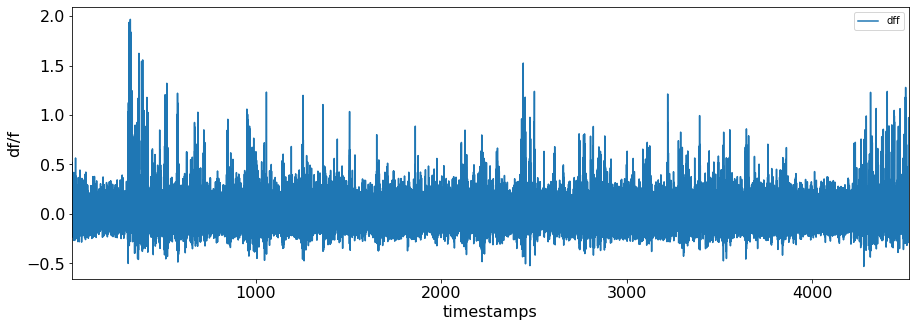

In [65]:
# Plot timeseries
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)

# Clean up plot
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('df/f',fontsize=16)
plt.xlabel('timestamps',fontsize=16)

# Load stimulus data into memory
The stimulus table is shared across all experiments (imaging planes) in a session. We can therefore use the stimulus table for just one experiment.

We are going to drop the `image_set` column because it is not informative for our purposes. We can then view the first 10 rows of the stimulus table.

In [66]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
stimulus_table.head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25020,18001.0,0,im065,0,False,17986,308.92068,309.17088,False
1,0.25018,18046.0,0,im065,1,False,18031,309.67130,309.92148,False
2,0.25021,18091.0,0,im065,2,False,18076,310.42190,310.67211,False
3,0.25000,NaN,8,omitted,0,True,18120,311.15584,311.40584,False
4,0.25020,18181.0,0,im065,3,False,18166,311.92309,312.17329,False
5,0.25020,18226.0,0,im065,4,False,18211,312.67370,312.92390,False
6,0.25023,18271.0,2,im066,5,False,18256,313.42434,313.67457,True
7,0.25020,18316.0,2,im066,6,False,18301,314.17497,314.42517,False
8,0.25021,18361.0,2,im066,7,False,18346,314.92558,315.17579,False


## Describe stimulus omissions
An important feature of the task is that stimuli are shown at a very regular cadence (250 ms on, 500 ms off), but stimuli are randomly omitted with a probability of ~5%. These unexpected and random stimulus omissions could be perceived as an expectation violation by the mouse.

Omitted stimuli are denoted in the `stimulus_table` by the `omitted` column. `True` means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

We can look at the first 10 examples of omitted stimuli as follows. Note that each 'omitted' stimulus still has a 'start_time' and a 'stop_time' associated with it. This actually represents the time that a stimulus would have been shown, had it not been omitted.

Stimulus omissions are also indicated in the `image_name` column by the string `omitted`

In [67]:
stimulus_table.query('omitted').head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
3,0.25,NaN,8,omitted,0,True,18120,311.15584,311.40584,False
38,0.25,NaN,8,omitted,1,True,19695,337.42724,337.67724,False
71,0.25,NaN,8,omitted,2,True,21180,362.19751,362.44751,False
77,0.25,NaN,8,omitted,3,True,21450,366.70116,366.95116,False
88,0.25,NaN,8,omitted,4,True,21945,374.95793,375.20793,False
105,0.25,NaN,8,omitted,5,True,22710,387.71831,387.96831,False
110,0.25,NaN,8,omitted,6,True,22935,391.47141,391.72141,False
150,0.25,NaN,8,omitted,7,True,24735,421.49592,421.74592,False
166,0.25,NaN,8,omitted,8,True,25455,433.50571,433.75571,False


# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `mindscope_utilities` package has a convenience function to do this. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [68]:
cell_id = cell_ids[11]
etr = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
)
etr

,time,dff,event_number,event_time
0,-3.00,-0.125992,0,311.15584
1,-2.98,-0.125992,0,311.15584
2,-2.96,-0.125992,0,311.15584
3,-2.94,-0.124879,0,311.15584
4,-2.92,-0.115022,0,311.15584
...,...,...,...,...
58690,2.92,-0.016571,194,3916.29897
58691,2.94,-0.021637,194,3916.29897
58692,2.96,-0.023620,194,3916.29897
58693,2.98,-0.023620,194,3916.29897


We can see that the output has colums for
* `time` - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* `dff` - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the `event_triggered_response` function we had passed `y = 'events'`, this column would be events instead of dff.
* `event_number` - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* `event_time` - this is the time of each event



The docstring for the `event_triggered_response` function can be viewed as follows:

In [69]:
mindscope_utilities.event_triggered_response?

## Plot an event triggered response

The output format of the `event_triggered_response` function is designed to plug directly into Seaborn's `lineplot` plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

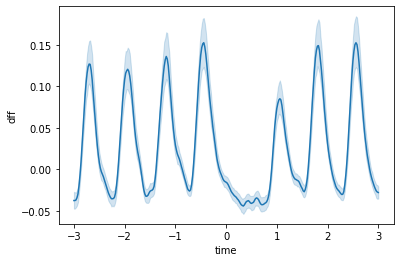

In [70]:
# Plot event triggered average
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

Note that the regular, image-driven responses with a 750 ms inter-stimulus interval are visible everywhere except at t=0, which is when the unexpectedly omitted stimulus occured. We can make this more clear by adding markers for the times of image presentations. Each image is presented for 250 ms.

Text(0.5, 0, 'time from omission (s)')

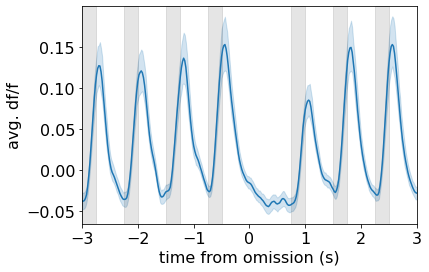

In [71]:
# Plot event triggered average
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

# Add gray bars to show stimulus times
image_times = np.concatenate([np.arange(-3,0,0.75),np.arange(0.75,3,0.75)])
for image_time in image_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)

# Clean up the plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('avg. df/f',fontsize=16)
plt.xlabel('time from omission (s)',fontsize=16)

### Make a function to plot an event triggered average in one line

If we make a wrapper function that combines the process of calculating and plotting the event triggered response, it can be called in a single line below. By having `event_query` input variable, we can use this function to plot responses to any event of interest (omisisons, changes, hits/misses, specific images, etc)

In [72]:
def make_event_triggered_plot(df, x, y, event_query, stimulus_table, ax, t_before=3, t_after=3):
    # Build event triggered response
    etr = mindscope_utilities.event_triggered_response(
        data = df,
        t = 'timestamps',
        y = y,
        event_times = stimulus_table.query(event_query)['start_time'],
        t_before=t_before,
        t_after=t_before,
        output_sampling_rate = 50,
    )
    # Plot event triggered response
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax
    )

Now plot the omission triggered response for the same cell using filtered events (these events extracted from the deltaF/F timeseries using an event extraction algorithm, then smoothed with a half-gaussian kernel) instead of dff.

Text(0.5, 0, 'time from omission (s)')

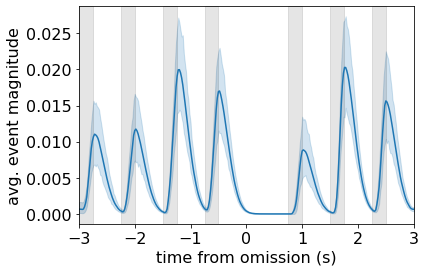

In [73]:
# Make a figure and add event triggered response
fig, ax = plt.subplots()
make_event_triggered_plot(
    df = neural_data.query('cell_specimen_id == @cell_id'), 
    x = 'time', 
    y = 'filtered_events', 
    stimulus_table = stimulus_table,
    event_query = 'omitted', 
    ax=ax
)

# Add stimulus times
for image_time in image_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)

# clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('avg. event magnitude',fontsize=16)
plt.xlabel('time from omission (s)',fontsize=16)

## Plot the responses for 10 sample cells
We can then iterate over 10 randomly chosen cells and plot their activity during omissions. 

100%|██████████| 10/10 [00:41<00:00,  4.20s/it]


Text(0.5, 0, 'time from omission (s)')

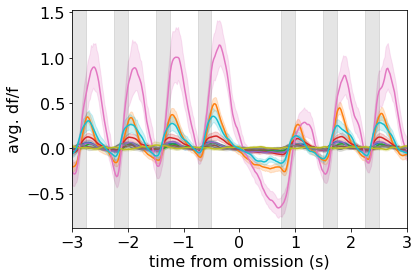

In [74]:
# Fix random seed for reproducibility
np.random.seed(0)

# Make figure and add 10 cells
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    make_event_triggered_plot(
        df = neural_data.query('cell_specimen_id == @cell_id'), 
        x = 'time', 
        y = 'dff', 
        stimulus_table = stimulus_table,
        event_query = 'omitted', 
        ax=ax
    )

# Add stimulus information
for image_time in image_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)

# clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('avg. df/f',fontsize=16)
plt.xlabel('time from omission (s)',fontsize=16)

Interestingly, not all SST cells in this session do the same thing! 

## Calculate the mean response for each of the individual imaging planes in this experiment
By iterating over experiment IDs, we can also calculate the mean response for each of the 7 imaging planes. Do Sst cells in different visual areas respond to omissions in a distinct way? 

We will first use a Pandas `groupby` and `mean` operations to get the mean timeseries for each cell in that imaging plane:

In [75]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
)

In [76]:
mean_dff_by_experiment.head()

,ophys_experiment_id,timestamps,dff
0,850517344,8.89238,0.812925
1,850517344,8.98560,0.721458
2,850517344,9.07882,0.613317
3,850517344,9.17204,0.160570
4,850517344,9.26526,0.296787


We can then iterate over our 7 experiment IDs and use our `make_event_triggered_plot` wrapper function to calculate and plot the omission triggered response for that imaging plane:

100%|██████████| 7/7 [00:29<00:00,  4.24s/it]


Text(0.5, 0, 'time from omission (s)')

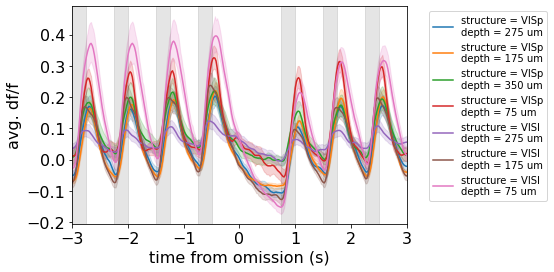

In [77]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    
    make_event_triggered_plot(
        df = mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'), 
        x = 'time', 
        y = 'dff', 
        stimulus_table = stimulus_table,
        event_query = 'omitted', 
        ax=ax
    )
    
    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]

    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))

# Add image times
for image_time in image_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)

plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('avg. df/f',fontsize=16)
plt.xlabel('time from omission (s)',fontsize=16)

There are clearly some large differences in the way that Sst cells respond to these unexpected stimulus omissions by area and cortical depth.

This example could be extended to include cells from the other two cre-lines in the dataset: The VIP-Cre line which labels VIP+ inhibitory interneurons and the Slc17a7 line, which is a pan-excitatory line.

In [78]:
session_table['cre_line'].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

In addition, responses to different stimuli could be explored, along with responses relative to other behavioral measures, such as licking.

For a full description of the dataset and all available data streams, see the Visual Behavior Project Description at:
https://portal.brain-map.org/explore/circuits/visual-behavior-2p

# Looking at Behavioral data

For each session, we also record behavioral variables like the pupil diameter, and the running speed of the animal. The mouse is not rewarded nor punished for running, but the mice show interesting running behavior. 

In [79]:
running_df = experiments[ophys_experiment_ids[0]].running_speed.reset_index()
running_df.head()


,index,timestamps,speed
0,0,8.90903,0.037876
1,1,8.92569,0.059147
2,2,8.94237,0.089502
3,3,8.95906,0.123695
4,4,8.97573,0.156781


Let's plot the running speed triggered on image changes


Text(0.5, 0, 'time from image change (s)')

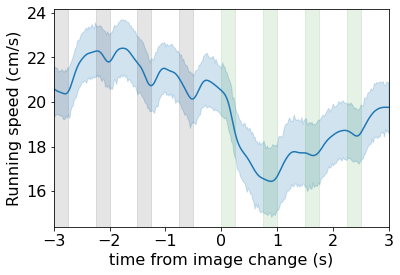

In [80]:
# plot event triggered response for running
fig, ax = plt.subplots()
make_event_triggered_plot(
    df = running_df, 
    x = 'time', 
    y = 'speed', 
    stimulus_table = stimulus_table,
    event_query = 'is_change', 
    ax=ax
)

# Add stimulus information
pre_change_times = np.arange(-3,0,0.75)
post_change_times = np.arange(0,3,0.75)
for image_time in pre_change_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)
for image_time in post_change_times:
  plt.axvspan(image_time,image_time+0.25,color='g',alpha=.1)

# clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Running speed (cm/s)',fontsize=16)
plt.xlabel('time from image change (s)',fontsize=16)

We can also examine the pupil diameter


In [81]:
pupil_df = experiments[ophys_experiment_ids[0]].eye_tracking.reset_index()
pupil_df.head()

,frame,timestamps,cr_area,eye_area,pupil_area,likely_blink,eye_center_x,eye_center_y,eye_area_raw,eye_height,eye_width,eye_phi,pupil_center_x,pupil_center_y,pupil_area_raw,pupil_height,pupil_width,pupil_phi,cr_center_x,cr_center_y,cr_area_raw,cr_height,cr_width,cr_phi
0,0,0.15241,158.650835,58380.648445,17096.182214,False,321.187154,193.120836,58380.648445,121.973016,152.354497,-0.003290,308.067406,193.173291,17096.182214,64.935107,73.769125,-0.111849,309.920950,205.437985,158.650835,6.563386,7.694220,-0.393979
1,1,0.19144,162.372672,58244.188810,16973.599190,False,321.358897,193.302394,58244.188810,121.756181,152.269076,-0.005593,308.138934,192.952591,16973.599190,65.536894,73.504180,-0.181119,309.709005,205.575629,162.372672,6.572016,7.864379,-0.287380
2,2,0.19295,147.387372,58558.325176,17583.839614,False,320.602849,192.592676,58558.325176,122.330780,152.371250,-0.012989,305.042148,193.524925,17583.839614,64.568419,74.813836,-0.209963,307.983162,205.284388,147.387372,6.347343,7.391260,-0.476244
3,3,0.21423,157.636080,58979.411351,17217.621913,False,320.011114,192.972895,58979.411351,122.734693,152.961882,-0.016633,305.368072,191.832906,17217.621913,65.406398,74.030664,-0.233485,307.408851,205.206396,157.636080,6.484105,7.738481,-0.553877
4,4,0.24469,149.794597,59048.218673,15803.980625,False,319.239892,193.222643,59048.218673,122.871430,152.969911,-0.037490,308.577955,188.934168,15803.980625,65.406191,70.926464,0.085407,307.378139,205.896148,149.794597,6.346950,7.512443,-0.576068


Text(0.5, 0, 'time from image-change (s)')

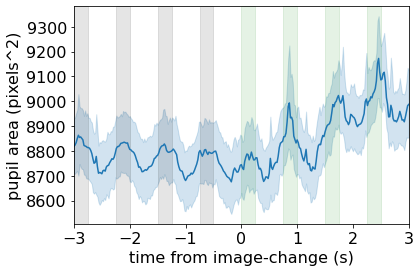

In [82]:
# Compute event triggered response
fig, ax = plt.subplots()
make_event_triggered_plot(
    df = pupil_df, 
    x = 'time', 
    y = 'pupil_area', 
    stimulus_table = stimulus_table,
    event_query = 'is_change', 
    ax=ax
)

# Add stimulus information
pre_change_times = np.arange(-3,0,0.75)
post_change_times = np.arange(0,3,0.75)
for image_time in pre_change_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)
for image_time in post_change_times:
  plt.axvspan(image_time,image_time+0.25,color='g',alpha=.1)

# clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('pupil area (pixels^2)',fontsize=16)
plt.xlabel('time from image-change (s)',fontsize=16)

We see a couple interesting things in this plot. First, the pupil area modulates with each image presentation. Second, when the image is omitted we have sustained dilation for a few hundred milliseconds. 

# Tracking cells across sessions


In this dataset, we attempt to record from the same cells across 6 image sessions. Due to experimental constraints, and the variable nature of neural circuits, we do not always have data from the same cells across all 6 sessions.

Our first task is to find the other ophys sessions associated with the session we have been using. We can use the `mouse_id` column of the `ophys_session_table` to find the relevant sessions


In [83]:
ophys_session_id = 849304162 
session_table.loc[ophys_session_id].mouse_id

440631

In [84]:
session_table.query('mouse_id =="440631"')

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
849304162,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,121.0,Sst-IRES-Cre,GCaMP6f,1.0,0,18.0,0,849525884,"[850517344, 850517346, 850517348, 850517350, 8...","[1018028135, 1018028138, 1018028141, 101802814...",VisualBehaviorMultiscope,2019-04-11 08:28:26.000000,OPHYS_1_images_A
850667270,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,122.0,Sst-IRES-Cre,GCaMP6f,2.0,0,19.0,1,850817466,"[851093285, 851093287, 851093289, 851093291]","[1018028135, 1018028138, 1018028144, 1018028153]",VisualBehaviorMultiscope,2019-04-12 08:41:31.226740,OPHYS_2_images_A_passive
852794141,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,127.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,852974537,"[853363739, 853363743, 853363745, 853363747, 8...","[1018028135, 1018028138, 1018028141, 101802814...",VisualBehaviorMultiscope,2019-04-17 08:54:40.065688,OPHYS_4_images_B
853416532,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,128.0,Sst-IRES-Cre,GCaMP6f,5.0,0,1.0,5,853505213,"[853988430, 853988437, 853988446, 853988448, 8...","[1018028141, 1018028144, 1018028147, 101802815...",VisualBehaviorMultiscope,2019-04-18 08:47:33.972217,OPHYS_5_images_B_passive
854060305,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,129.0,Sst-IRES-Cre,GCaMP6f,6.0,0,2.0,6,854283407,"[854759890, 854759894, 854759896, 854759898, 8...","[1018028135, 1018028138, 1018028141, 101802814...",VisualBehaviorMultiscope,2019-04-19 08:37:15.454259,OPHYS_6_images_B
855711263,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,133.0,Sst-IRES-Cre,GCaMP6f,3.0,2,22.0,7,855826937,"[856123117, 856123119, 856123124, 856123126, 8...","[1018028135, 1018028138, 1018028141, 101802814...",VisualBehaviorMultiscope,2019-04-23 08:47:00.508479,OPHYS_3_images_A
857040020,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,135.0,Sst-IRES-Cre,GCaMP6f,2.0,1,23.0,8,857230827,"[857698006, 857698014, 857698018]","[1018028138, 1018028147, 1018028150]",VisualBehaviorMultiscope,2019-04-25 08:12:38.345288,OPHYS_2_images_A_passive


Previously we were looking at `849304162` which was a familiar image-set session. 

Now we are going to look at a session collected with the novel image set. You can see this information from the `session_type` column.

Again we are going to download the associated NWB files. 


In [85]:
novel_ophys_session_id = 854060305
novel_ophys_experiment_ids = session_table.loc[novel_ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in novel_ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

Next, we will rebuild our dataframe of neural data with both the familiar and novel sessions combined. 


In [86]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 13/13 [00:37<00:00,  2.89s/it]


Now our dataframe has the same columns as before, but we have two ophys sessions

In [87]:
neural_data.head()


,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,8.89238,1080857656,1086550481,1.196615,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,8.98560,1080857656,1086550481,1.130732,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,9.07882,1080857656,1086550481,1.041409,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,9.17204,1080857656,1086550481,0.148351,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,9.26526,1080857656,1086550481,0.285266,0.0,0.0,850517344,849304162,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


In [88]:
neural_data.ophys_session_id.unique()

array([849304162, 854060305])

Finally, we need to get the stimulus table for the novel session


In [89]:
novel_stimulus_table = experiments[novel_ophys_experiment_ids[0]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
novel_stimulus_table.head()

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25021,18001.0,0,im000,0,False,17986,310.55053,310.80074,False
1,0.25020,18046.0,0,im000,1,False,18031,311.30115,311.55135,False
2,0.25021,18091.0,0,im000,2,False,18076,312.05179,312.30200,False
3,0.25020,18136.0,0,im000,3,False,18121,312.80242,313.05262,False
4,0.25021,18181.0,0,im000,4,False,18166,313.55303,313.80324,False


# Comparing cells across sessions

ROIs are identified for each session, and then cells are matched across sessions. Cells are not always matched across sessions. You can read more in our [white paper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)

* `cell_roi_id` refers to a single ROI (region of interest) for a single session. 

* `cell_specimen_id` refers to a cell that has been tracked across sessions. A cell is always given a cell_specimen_id, even if it is only identified in a single session. 


In [90]:
# Find cell_specimen_ids present in both sessions
novel_session_cell_ids = neural_data.query('ophys_session_id == @novel_ophys_session_id').cell_specimen_id.unique()
matched_cells = np.intersect1d(cell_ids, novel_session_cell_ids)
print(matched_cells)

[1086547630 1086547796 1086547993 1086548072 1086548118 1086548658
 1086548969 1086549303 1086549491 1086549726 1086549813 1086549949
 1086550481 1086550544 1086551151 1086551209 1086551301 1086551457
 1086551540 1086551645 1086552709 1086553271 1086553602 1086553836
 1086555222 1086556317 1086556532 1086557083 1086557208 1086557304
 1086557434 1086557639 1086558114 1086558224 1086558510 1086559064
 1086559206 1086559885 1086559968]


In [91]:
print('Cells in familiar session ' +str(len(cell_ids)))
print('Cells in novel session '+str(len(novel_session_cell_ids)))
print('Cells matched in both sessions '+str(len(matched_cells)))


Cells in familiar session 79
Cells in novel session 53
Cells matched in both sessions 39


Now lets plot a random cell that was tracked across sessions

Text(0.5, 0, 'time from omission (s)')

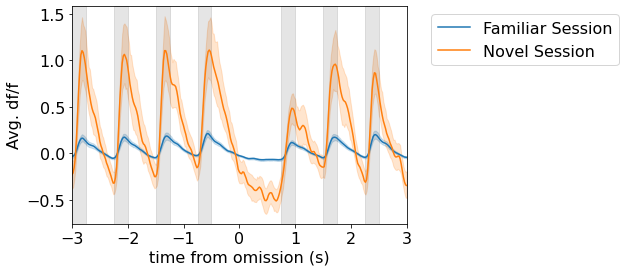

In [92]:
# Make figure, and pick cell
fig, ax = plt.subplots()
cell_id = matched_cells[0]

# Add first session average response
make_event_triggered_plot(
    df = neural_data.query('(cell_specimen_id == @cell_id)&(ophys_session_id ==@ophys_session_id)'), 
    x = 'time', 
    y = 'dff', 
    stimulus_table = stimulus_table,
    event_query = 'omitted', 
    ax=ax
)

# Add new session average response
make_event_triggered_plot(
    df = neural_data.query('(cell_specimen_id == @cell_id)&(ophys_session_id ==@novel_ophys_session_id)'), 
    x = 'time', 
    y = 'dff', 
    stimulus_table = novel_stimulus_table,
    event_query = 'omitted', 
    ax=ax
)

# Add stimulus information
for image_time in image_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)

# Clean up plot
plt.xlim(-3,3)
plt.legend(labels=['Familiar Session', 'Novel Session'], bbox_to_anchor=(1.05, 1),fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Avg. df/f',fontsize=16)
plt.xlabel('time from omission (s)',fontsize=16)


Its now very clear that this cell has a larger amplitude response on the novel session.





# Average response across sessions

Finally, lets look at the average response across imaging planes for the two sessions. 


In [93]:
mean_dff_by_session = (
    neural_data
    .groupby(['ophys_session_id','ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
)
mean_dff_by_session.head()

,ophys_session_id,ophys_experiment_id,timestamps,dff
0,849304162,850517344,8.89238,0.812925
1,849304162,850517344,8.98560,0.721458
2,849304162,850517344,9.07882,0.613317
3,849304162,850517344,9.17204,0.160570
4,849304162,850517344,9.26526,0.296787


Let's repeat our per-experiment plot for the original session

Text(0.5, 0, 'time from omission (s)')

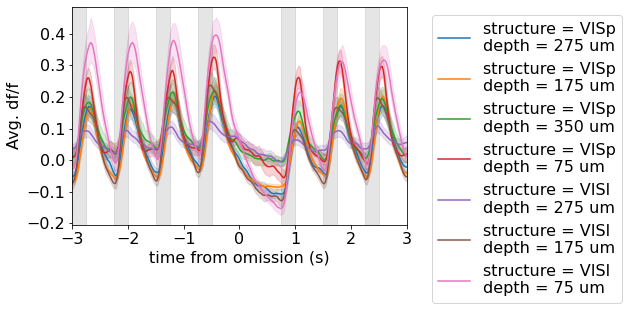

In [94]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for experiment_id in ophys_experiment_ids:
  make_event_triggered_plot(
      df = mean_dff_by_session.query('(ophys_session_id ==@ophys_session_id)&(ophys_experiment_id==@experiment_id)'), 
      x = 'time', 
      y = 'dff', 
      stimulus_table = stimulus_table,
      event_query = 'omitted', 
      ax=ax
  )
  # get some metadata to add to the legend
  this_exp = neural_data.query('ophys_experiment_id == @experiment_id')
  structure = this_exp['targeted_structure'].iloc[0]
  depth = this_exp['imaging_depth'].iloc[0]

  # append a string to our list of legend text
  legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1),fontsize=16)

# Add image times
for image_time in image_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)

# Clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Avg. df/f',fontsize=16)
plt.xlabel('time from omission (s)',fontsize=16)


Let's make the same plot for the novel session

Text(0.5, 0, 'time from omission (s)')

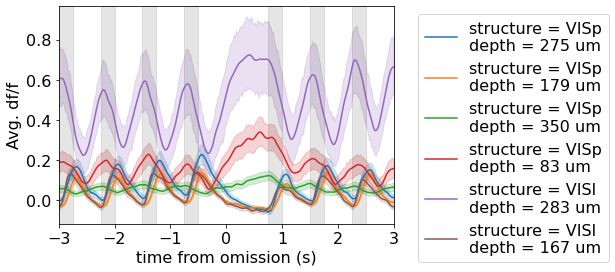

In [95]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

for experiment_id in novel_ophys_experiment_ids:
  make_event_triggered_plot(
      df = mean_dff_by_session.query('(ophys_session_id == @novel_ophys_session_id)&(ophys_experiment_id ==@experiment_id)'), 
      x = 'time', 
      y = 'dff', 
      stimulus_table = novel_stimulus_table,
      event_query = 'omitted', 
      ax=ax
  )
  # get some metadata to add to the legend
  this_exp = neural_data.query('ophys_experiment_id == @experiment_id')
  structure = this_exp['targeted_structure'].iloc[0]
  depth = this_exp['imaging_depth'].iloc[0]

  # append a string to our list of legend text
  legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1),fontsize=16)

# Add image times
for image_time in image_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)

# Clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Avg. df/f',fontsize=16)
plt.xlabel('time from omission (s)',fontsize=16)

# Looking at Image Changes

In addition to image omissions, the image identity also changes in this dataset. We can repeat our analysis aligned to image changes

First, lets return to our example cell matched across sessions

Text(0.5, 0, 'time from image change (s)')

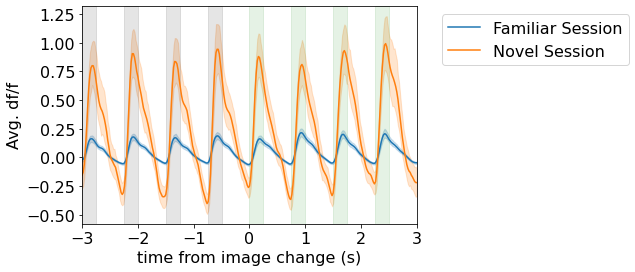

In [96]:
fig, ax = plt.subplots()
cell_id = matched_cells[0]
make_event_triggered_plot(
    df = neural_data.query('(cell_specimen_id == @cell_id)&(ophys_session_id ==@ophys_session_id)'), 
    x = 'time', 
    y = 'dff', 
    stimulus_table = stimulus_table,
    event_query = 'is_change', 
    ax=ax
)
make_event_triggered_plot(
    df = neural_data.query('(cell_specimen_id == @cell_id)&(ophys_session_id ==@novel_ophys_session_id)'), 
    x = 'time', 
    y = 'dff', 
    stimulus_table = novel_stimulus_table,
    event_query = 'is_change', 
    ax=ax
)

# Plot the pre-change and post-change image times
pre_change_times = np.arange(-3,0,0.75)
post_change_times = np.arange(0,3,0.75)
for image_time in pre_change_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)
for image_time in post_change_times:
  plt.axvspan(image_time,image_time+0.25,color='g',alpha=.1)

# Clean up plot
plt.xlim(-3,3)
plt.legend(labels=['Familiar Session', 'Novel Session'], bbox_to_anchor=(1.05, 1),fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Avg. df/f',fontsize=16)
plt.xlabel('time from image change (s)',fontsize=16)

This example cell doesn't seem to modulate its response to image changes. Lets look at the average across imaging planes for each session. 


Text(0.5, 0, 'time from image change (s)')

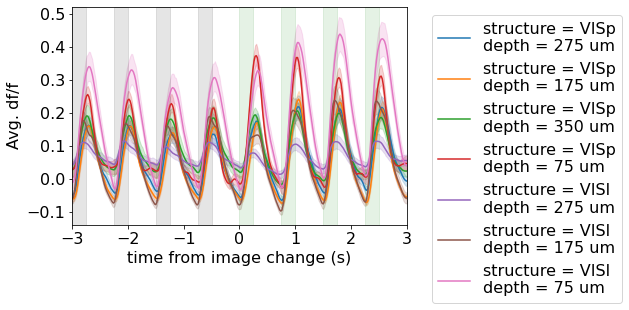

In [97]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for experiment_id in ophys_experiment_ids:
  make_event_triggered_plot(
      df = mean_dff_by_session.query('(ophys_session_id ==@ophys_session_id)&(ophys_experiment_id==@experiment_id)'), 
      x = 'time', 
      y = 'dff', 
      stimulus_table = stimulus_table,
      event_query = 'is_change', 
      ax=ax
  )
  # get some metadata to add to the legend
  this_exp = neural_data.query('ophys_experiment_id == @experiment_id')
  structure = this_exp['targeted_structure'].iloc[0]
  depth = this_exp['imaging_depth'].iloc[0]

  # append a string to our list of legend text
  legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1),fontsize=16)

# Add image times
for image_time in pre_change_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)
for image_time in post_change_times:
  plt.axvspan(image_time,image_time+0.25,color='g',alpha=.1)

# Clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Avg. df/f',fontsize=16)
plt.xlabel('time from image change (s)',fontsize=16)

Text(0.5, 0, 'time from image change (s)')

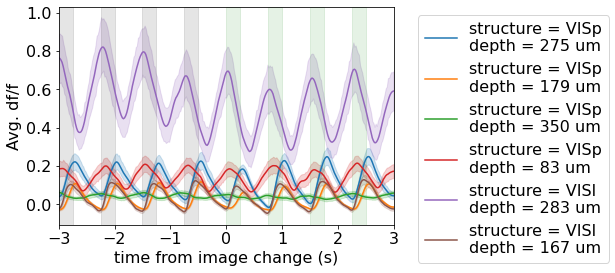

In [98]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

for experiment_id in novel_ophys_experiment_ids:
  make_event_triggered_plot(
      df = mean_dff_by_session.query('(ophys_session_id == @novel_ophys_session_id)&(ophys_experiment_id ==@experiment_id)'), 
      x = 'time', 
      y = 'dff', 
      stimulus_table = novel_stimulus_table,
      event_query = 'is_change', 
      ax=ax
  )
  # get some metadata to add to the legend
  this_exp = neural_data.query('ophys_experiment_id == @experiment_id')
  structure = this_exp['targeted_structure'].iloc[0]
  depth = this_exp['imaging_depth'].iloc[0]

  # append a string to our list of legend text
  legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1),fontsize=16)

# Add image times
for image_time in pre_change_times:
  plt.axvspan(image_time,image_time+0.25,color='k',alpha=.1)
for image_time in post_change_times:
  plt.axvspan(image_time,image_time+0.25,color='g',alpha=.1)

# Clean up plot
plt.xlim(-3,3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Avg. df/f',fontsize=16)
plt.xlabel('time from image change (s)',fontsize=16)

Interestingly, we see more modulation by the image change in the familiar session, and less in the novel session. 


# Summary

Hopefully this tutorial has introduced the various aspects of this dataset, and demonstrated how to access the data. Please reach out to the visual behavior team if you have questions about the data, or how to access it.